Sample: Cy3-DNA Cy5-H3 nucleosome, spiked in to final 5 nM SWR1(ASAP), 25 nM Cy5.5-ZB, 1 mM ATP.
Imaging buffer: PCA/PCD

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from time import time

## User input

In [2]:
sample_prefix = 'E:\\Ashlee\\PacBio\\20190207_D1-3_exchange_test\\Sample\\m190207_181237_42131_c000469922559900001500000112312180_s1_p0'
color1 = 0
color2 = 2
leakage = np.array([[0.        , 0.48921841, 0.09134705, 0.02373513],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.3349036856391455],
       [0.        , 0.        , 0.        , 0.        ]])
gamma = np.ones((4,))
gamma[2] = 1.3709926961993117

In [3]:
def plot_one_trace(data, traceID, time_axis):
#     plt.figure(figsize=(15, 2))
    trc = data[traceID]
    time_axis = time_axis
    shape = data.shape
    if len(shape) == 2:
        plt.plot(time_axis, trc)
    else:
        n_channels = data.shape[1]
        for j in [0, 1, 3]:
            plt.plot(time_axis, trc[j], color=colors[j], linewidth=0.5)
        plt.xlabel('Time (s)')
        plt.ylabel('Intensity')
        plt.title('Trace ' + str(traceID))

In [4]:
def plot_one_trace_bgs(data, traceID, time_axis, background, foi):
#     plt.figure(figsize=(15, 2))
    trc = data[traceID, :, foi]
    corrected = np.zeros((4, n_frames))
    for j in [0, 2, 3]:
        corrected[j] = trc[j] - bg[traceID, j]
        if j > 0:
            corrected[j] = corrected[j] - leakage[0, j] * corrected[0]
        if j > 1:
            corrected[j] = corrected[j] - leakage[1, j] * corrected[1]
        if j > 2:
            corrected[j] = corrected[j] - leakage[2, j] * corrected[2]
        plt.plot(time_axis[foi], corrected[j] , c=colors[j], linewidth=.5)
        plt.xlabel('Time (s)')
        plt.ylabel('Intensity')
        plt.title('Trace ' + str(traceID))

In [5]:
def plot_traces(n, data, indices, time_axis):
    plt.figure(figsize=(15, n*2))
#     if n % 2 == 1:
#         n = n-1
    for i in range(n):
        plt.subplot(n, 1, i+1)
        plot_one_trace(data, indices[i], time_axis)
#         
#         if len(data.shape) == 2:
#             plt.plot(time_axis, trc)
#         else:
#             for j in range(data.shape[1]):
#                 plt.plot(time_axis, trc[j], color=colors[j], linewidth=0.5)

#         plt.xlabel('Time (s)')
#         plt.ylabel('Intensity')
#         plt.title('Trace ' + str(indices[i]))
    plt.subplots_adjust(hspace=0.9)

In [6]:
def plot_traces_caller(n, toi, sorting_index, time_axis, foi, start, end, dyes, save=True):
    plot_traces(n, toi, sorting_index[start:end], time_axis[foi])
    filename = "%s_%d-%d_most_%s_anticorrelated.png" %(sample_prefix, start, end, dyes)
    if save:
        plt.savefig(filename, dpi=200)

In [7]:
def decode_and_plot(traces, traceID, decode_array, colors, foi, background, gamma, leakage, channels):
#     channels = range(4)
    trace = decode_array[traces[traceID]]
    plt.figure(figsize=(13,4))   
    
    for i in channels:
        trace[i] = trace[i] - background[i]
        print(i, np.mean(trace[i, -10:]))
        trace[i] = trace[i]*gamma[i]
        for j in channels:
            trace[i] = trace[i] - trace[j] * leakage[j, i]
    
    for j in channels:
        plt.plot(time_axis[foi], trace[j], color=colors[j], linewidth=0.4, alpha=0.9)

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    
    plt.figure(figsize=(13,4))
    don = trace[0]
    acc = trace[2]
    fret = acc/(don + acc)
    plt.plot(time_axis[foi], fret, linewidth=0.4)
    plt.ylim([-0.1, 1.1])
    print(fret)
    
    plt.xlabel('Time (s)')
    plt.ylabel('FRET efficiency')
    
    return fret


## Load data

In [8]:
start = time()
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

print("Time passed: " + str(time() - start))

Time passed: 0.2516000270843506


In [10]:
traces = raw_traces # skipping decode step to save memory

## Preprocessing

In [11]:
start_frame = 1500
end_frame = 5700
foi = range(start_frame, end_frame) # frames of interest
n_frames = len(foi)

In [12]:
first_10_frames = np.zeros((n_traces, 4, 10), dtype=np.uint8)
first_10_frames = raw_traces[:, :, range(start_frame, start_frame + 10)]
avg_intens = np.mean(first_10_frames, axis=2)

In [ ]:
# goodIDs = [] # indices of good traces
# badIDs = [] # indices of bad traces
# for i in range(n_traces):
#     bad = False
#     j = 0
#     trace = first_10_frames[i, j]
#     max_intens = np.max(trace)
#     min_intens = np.min(trace)
#     if max_intens == 255:
#         bad = True
#     elif min_intens == 0:
#         bad = True
#     if not bad:
#         goodIDs.append(i)
#     if bad:
#         badIDs.append(i)

# print("Got rid of %d traces" %(len(badIDs)))

In [ ]:
# n_good = len(goodIDs)
# first_10_frames_good = np.zeros((n_good, 4, 10), dtype=np.uint8)
# first_10_frames_good = first_10_frames[goodIDs]

In [ ]:
# avg_intens_good = np.mean(first_10_frames_good, axis=2)

## Plot intensity distributions

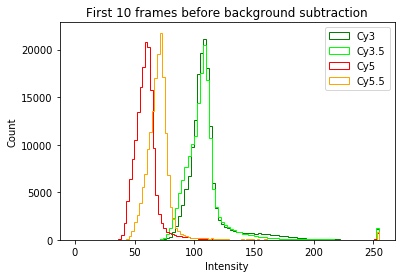

In [13]:
plt.figure()
for i in range(4):
    avg_intens_i = avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("First 10 frames before background subtraction")
plt.legend(lasers)
# plt.savefig(sample_prefix + '_intens_hist_before_bgs.png', dpi=200)

In [ ]:
# plt.figure()
# for i in range(4):
#     avg_intens_i = avg_intens_good.T[i]
#     min_i = min(avg_intens_i)
#     max_i = max(avg_intens_i)
#     plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
# plt.xlabel('Intensity')
# plt.ylabel('Count')
# plt.title("First 10 frames unsaturated before background subtraction")
# plt.legend(lasers)
# plt.savefig(sample_prefix + '_intens_hist_before_bgs.png', dpi=200)

In [ ]:
plt.figure(figsize=(7.5, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
# plt.title("Before background subtraction")
plt.savefig(sample_prefix + '_grid.png')

In [ ]:
# plt.figure(figsize=(7.5, 6))
# for i in range(4):
#     plt.subplot(2, 2, i+1)
# #     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
#     plt.scatter(hole_xy_plot[goodIDs, 0], hole_xy_plot[goodIDs, 1], 1, avg_intens_good.T[i])
#     plt.title(lasers[i] + ' intensity')
#     plt.colorbar()
# plt.subplots_adjust(hspace=0.3)
# plt.title("Before background subtraction")
# plt.savefig(sample_prefix + '_grid.png')

## Background subtraction

In [14]:
bg_file = open("E:\\Ashlee\PacBio\\20190207_D1-3_exchange_test\\PCA_blank\\m190207_164143_42131_c000469912559900001500000112312110_s1_p0_background.csv", "rb")
bg = np.loadtxt(bg_file, delimiter=",")

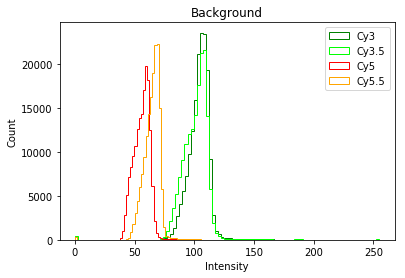

In [15]:
plt.figure()
for i in range(4):
    bg_i = bg.T[i]
    min_i = min(bg_i)
    max_i = max(bg_i)
    plt.hist(bg_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Background")
plt.legend(lasers)
plt.savefig(sample_prefix + "_background.png", dpi=200)

In [16]:
avg_intens_bgs = np.zeros((n_traces, 4), dtype=np.int16)
count = 0
for i in range(n_traces):
    new_intens = avg_intens[i] - bg[i]
    if np.min(new_intens) < -25:
#         avg_intens_bgs[i] = np.zeros((4, ), dtype=np.int16)
        avg_intens_bgs[i]= new_intens
    else:
        count += 1
        avg_intens_bgs[i]= new_intens
n_traces - count

1122

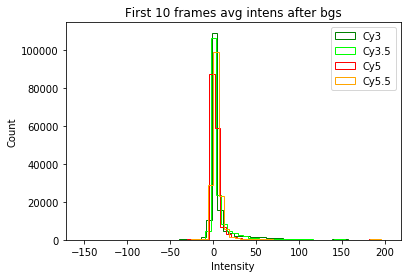

In [17]:
plt.figure()
for i in range(4):
    color_i = avg_intens_bgs.T[i]
    min_i = min(color_i)
    max_i = max(color_i)
    plt.hist(color_i, bins=50, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("First 10 frames avg intens after bgs")
plt.legend(lasers)
# plt.savefig(sample_prefix + '_intensity_hist_after_bgs.png', dpi=200)

## Filtering for wells that have desired intensity

In [18]:
channel = 2
low = 30
high = 180
sele_traces = []

for i in range(n_traces):
    if avg_intens_bgs[i, channel] > low and avg_intens_bgs[i, channel] < high:
        sele_traces.append(i)

print("%d traces have desired intensity range." %len(sele_traces))

3255 traces have desired intensity range.


4

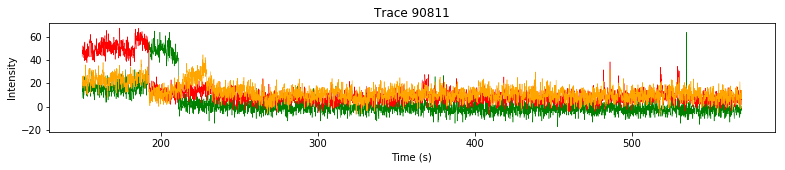

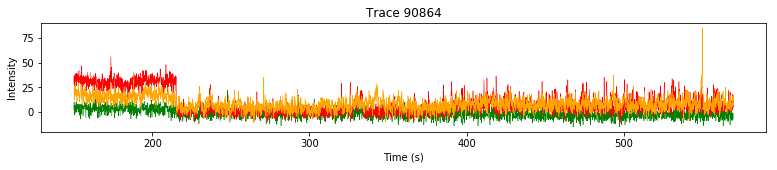

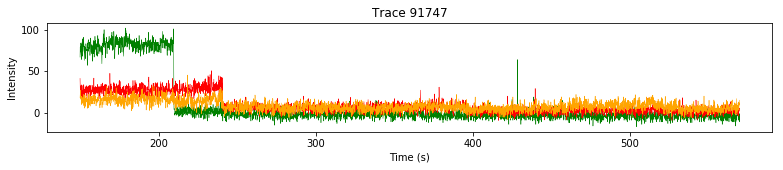

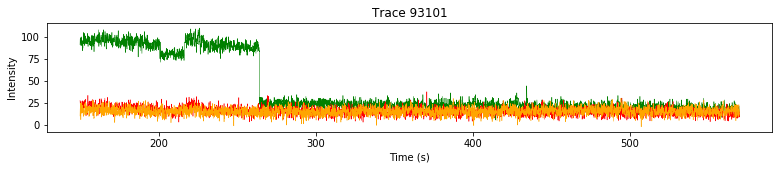

In [150]:
# display selected traces
count = 0
end_high = 20

for i in range(1800, 2000):
    traceID = sele_traces[i]
    last_10_frames = raw_traces[traceID, channel, [end_frame-10, end_frame]] - bg[traceID, channel]
    end_avg = np.mean(last_10_frames)
    if end_avg < end_high:
        plt.figure(figsize=(13,2))
        plot_one_trace_bgs(raw_traces, traceID, time_axis, bg, foi)
        count += 1

print("Showing %d traces." %count)

In [19]:
avg_intens_bgs.shape

(163482, 4)

In [20]:
aib_leakage = np.array(avg_intens_bgs)
for i in [0, 2, 3]:
    if i > 0:
        aib_leakage[:, i] = aib_leakage[:, i] - aib_leakage[:, 0] * leakage[0, i]
    if i > 2:
        aib_leakage[:, i] = aib_leakage[:, i] - aib_leakage[:, 2] * leakage[2, i]

In [21]:
sele_cy3 = aib_leakage[sele_traces, 0]
sele_cy5 = aib_leakage[sele_traces, 2]
sele_cy55 = aib_leakage[sele_traces, 3]

In [26]:
fret3_5 = sele_cy5 / (sele_cy3 + sele_cy5)
fret3_55 = sele_cy55 / (sele_cy3 + sele_cy55)
fret5_55 = sele_cy5 / (sele_cy5 + sele_cy55)

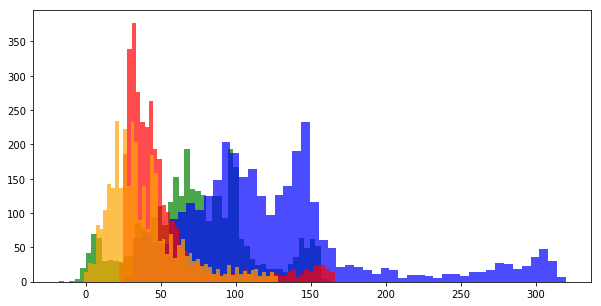

In [54]:
plt.figure(figsize = (10, 5))
h = plt.hist(sele_cy3, bins=50, alpha = 0.7, color = 'g')
h = plt.hist(sele_cy3 + sele_cy5, bins=50, alpha = 0.7, color = 'b')
h = plt.hist(sele_cy5, bins=50, alpha = 0.7, color = 'r')
h = plt.hist(sele_cy55, bins=50, alpha = 0.7, color = 'orange')

In [56]:
cy3_lo = -100
cy3_hi = 1000

cy5_lo = -100
cy5_hi = 1000

cy55_lo = -100
cy55_hi = 1000

cy3cy5_lo = -100
cy3cy5_hi = 200

sele_traces2 = []
for i in range(len(sele_traces)):
    traceID = sele_traces[i]
    cy3_i = avg_intens_bgs[traceID, 0]
    cy5_i = avg_intens_bgs[traceID, 2]
    cy55_i = avg_intens_bgs[traceID,3]
    cy3cy5_i = cy3_i + cy5_i
    if cy3_i > cy3_lo and cy3_i < cy3_hi:
        if cy5_i > cy5_lo and cy5_i < cy5_hi:
            if cy55_i > cy55_lo and cy55_i < cy55_hi:
                if cy3cy5_i > cy3cy5_lo and cy3cy5_i < cy3cy5_hi:
                    sele_traces2.append(traceID)

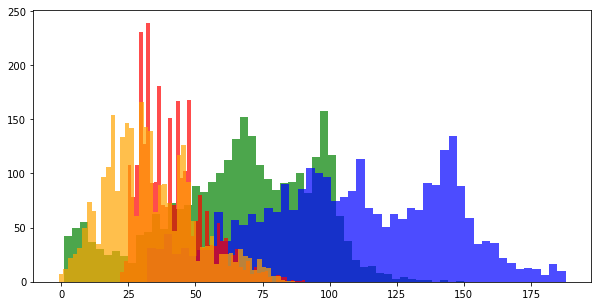

In [57]:
sele_cy3 = aib_leakage[sele_traces2, 0]
sele_cy5 = aib_leakage[sele_traces2, 2]
sele_cy55 = aib_leakage[sele_traces2, 3]

fret3_5 = sele_cy5 / (sele_cy3 + sele_cy5)
fret3_55 = sele_cy55 / (sele_cy3 + sele_cy55)
fret5_55 = sele_cy5 / (sele_cy5 + sele_cy55)

plt.figure(figsize = (10, 5))
h = plt.hist(sele_cy3, bins=50, alpha = 0.7, color = 'g')
h = plt.hist(sele_cy3 + sele_cy5, bins=50, alpha = 0.7, color = 'b')
h = plt.hist(sele_cy5, bins=50, alpha = 0.7, color = 'r')
h = plt.hist(sele_cy55, bins=50, alpha = 0.7, color = 'orange')

In [ ]:
plt.figure(figsize=(7.5, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens_bgs.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
# plt.title("Before background subtraction")
plt.savefig(sample_prefix + '_grid_bgs.png')
plt.show()

In [ ]:
bg_good = bg[goodIDs]
avg_intens_good_bgs = np.zeros((n_good, 4))
for i in range(n_good):
    avg_intens_good_bgs[i]= avg_intens_good[i] - bg_good[i]

In [ ]:
plt.figure()
for i in range(4):
    color_i = avg_intens_good_bgs.T[i]
    min_i = min(color_i)
    max_i = max(color_i)
    plt.hist(color_i, bins=50, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("First 10 frames unsaturated avg intens after bgs")
plt.legend(lasers)
# plt.savefig(sample_prefix + '_intensity_hist_after_bgs.png', dpi=200)

In [ ]:
plt.figure(figsize=(7.5, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[goodIDs, 0], hole_xy_plot[goodIDs, 1], 1, avg_intens_good_bgs.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
# plt.title("Before background subtraction")
# plt.savefig(sample_prefix + '_grid_bgs.png')
plt.show()

In [11]:
# Perform background subtraction for all traces
start = time()
traces = np.array(raw_traces[:, :, foi], dtype=np.int16)

print("Time passed: " + str(time() - start) + " s")

for i in range(n_traces):
    if i % 30000 == 0:
        print("Done with %d traces." %i)
    for j in range(4):
        traces[i, j] = traces[i, j] - bg[i, j]
        
print("Time passed: " + str(time() - start) + " s")

Time passed: 113.71979975700378 s
Done with 0 traces.
Done with 30000 traces.
Done with 60000 traces.
Done with 90000 traces.
Done with 120000 traces.
Done with 150000 traces.
Time passed: 123.62819981575012 s


## View a trace

In [ ]:
plt.figure(figsize=(13, 4))
traceID = np.random.randint(0, n_traces)
# traceID = 140760
plot_one_trace(traces, traceID, time_axis[foi])

In [ ]:
dynamic_trc = [140760]

## Sort by anticorrelation

In [ ]:
avg_intens_all_frames = np.mean(traces, axis=2)

In [ ]:
plt.figure()
for i in range(4):
    color_i = avg_intens_all_frames.T[i]
    min_i = min(color_i)
    max_i = max(color_i)
    plt.hist(color_i, bins=50, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("All frames avg intens after bgs")
plt.legend(lasers)

In [ ]:
start = time()
# zero-center the traces
centered_traces = np.zeros((n_traces, 2, len(foi)), dtype=np.int32)
for i in range(n_traces):
    centered_traces[i, 0] = traces[i, color1] - avg_intens_all_frames[i, color1]
    centered_traces[i, 1] = traces[i, color2] - avg_intens_all_frames[i, color2]
    
print(time() - start)

Compare with normalized traces?

i = np.random.randint(0, n_traces)
ct = centered_traces[i]
plt.figure(figsize=(15,5))

for j in range(2):
    plt.plot(time_axis[foi], ct[j], color=colors[j])
    j += 1 

plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

In [ ]:
# Compute cross-correlation
corr_list = np.zeros(n_traces,dtype=np.int64)
for i in range(n_traces):
    cy3 = centered_traces[i][0]
    cy5 = centered_traces[i][1]
    corr_list[i] = np.correlate(cy3, cy5)

sorting_index = np.argsort(corr_list)

## Leakage correction Cy3-Cy5

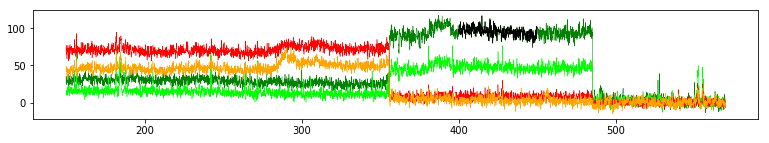

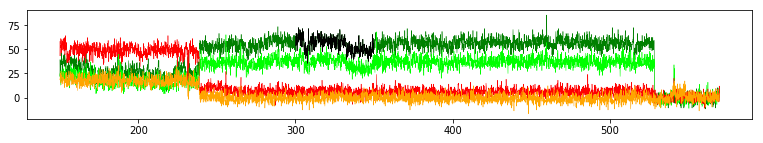

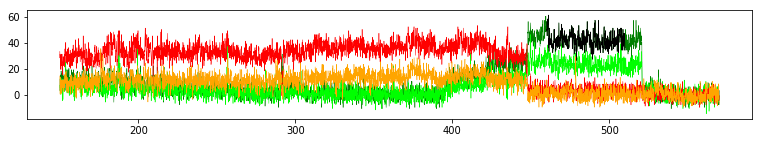

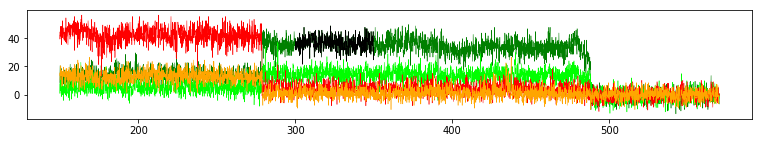

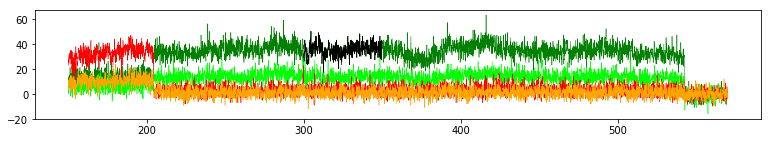

In [12]:
sele_traces = [159523, 16725, 68517, 34245, 82]
sele_ranges = [np.arange(4000, 4500), np.arange(3000, 3500), np.arange(4600, 5100), np.arange(3000, 3500), np.arange(3000, 3500)]
for i in range(len(sele_traces)):
    traceID = sele_traces[i]
    plt.figure(figsize=(13, 2))
    background = np.mean(traces[traceID, :, -100:], axis=1)
    for j in range(4):
        plt.plot(time_axis[foi], traces[traceID, j, :] - background[j], c=colors[j], linewidth=.5)
    rel_range = sele_ranges[i] - 1500
    plt.plot(time_axis[sele_ranges[i]],traces[traceID, 0, rel_range] - background[0] , c='k', linewidth=.5)

In [ ]:
sele_toi = np.zeros((len(sele_traces), 4,  500), dtype=np.int16)
for i in range(len(sele_traces)):
    traceID = sele_traces[i]
    background = np.mean(traces[traceID, :, -100:], axis=1)
    rel_range = sele_ranges[i] - 1500
    for j in range(4):
        sele_toi[i, j, :] = traces[traceID, j, rel_range].T - background[j]

In [ ]:
sele_traces = [159523, 16725, 68517, 34245, 82]

In [ ]:
sele_avg = np.mean(sele_toi, axis=2)
leakage_cf = []
for i in range(len(sele_traces)):
    leakage_cf.append(sele_avg[i, 2]/sele_avg[i, 0])

In [ ]:
leakage_cf2 = []
for i in range(len(sele_traces)):
    leakage_cf2.append(sele_avg[i, 1]/sele_avg[i, 0])

In [ ]:
leakage_cf4 = []
for i in range(1, len(sele_traces)):
    leakage_cf4.append(sele_avg[i, 3]/sele_avg[i, 0])

In [27]:
leakage = np.zeros((4, 4))
leakage[0, 2] = np.mean(leakage_cf)
leakage[0, 1] = np.mean(leakage_cf2)
leakage[0, 3] = np.mean(leakage_cf4)

NameError: name 'leakage_cf' is not defined

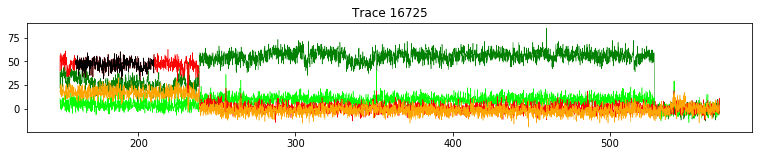

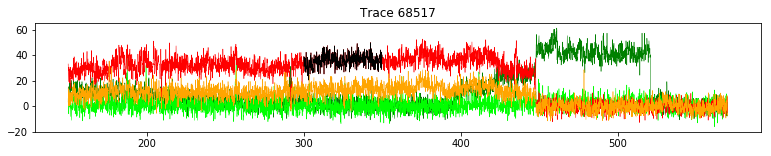

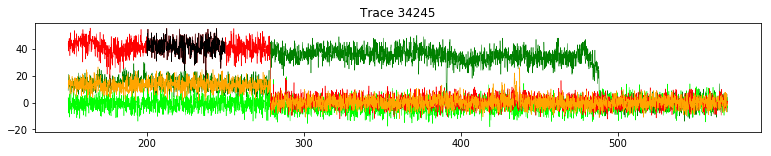

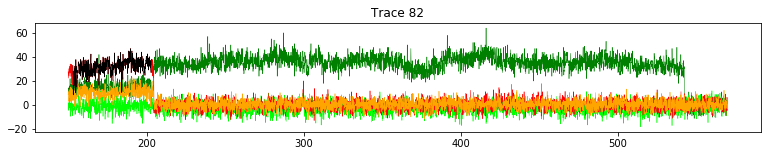

In [114]:
# sele_traces = [159523, 16725, 68517, 34245, 82]
traces = raw_traces
sele_traces2 = [16725, 68517, 34245, 82]
sele_ranges = [np.arange(1600, 2100), np.arange(3000, 3500), np.arange(2000, 2500), np.arange(1530, 2030)]
sele_toi2 = np.zeros((len(sele_traces), 4,  500), dtype=np.int16)

# for i in range(20):
#     sele_traces.append(sorting_index[i*20])
# sele_ranges = [np.arange(4000, 4500), np.arange(3000, 3500), np.arange(4600, 5100), np.arange(3000, 3500), np.arange(3000, 3500)]
for i in range(len(sele_traces2)):
    traceID = sele_traces2[i]
    trace = traces[traceID, :, foi]
    plt.figure(figsize=(13, 2))
#     plot_one_trace(traces - np.mean(traces[traceID, :, -10:], axis=1), traceID, time_axis[foi])
    background = np.mean(trace[:, -100:], axis=1)
    corrected = np.zeros((4, n_frames))
    for j in range(4):
        if i < 5:
            corrected[j] = trace[j] - background[j]
        else:
            corrected[j] = trace[j]
        if j > 0:
            corrected[j] = corrected[j] - leakage[0, j] * corrected[0]
        if j > 1:
            corrected[j] = corrected[j] - leakage[1, j] * corrected[1]
        if j > 2:
            corrected[j] = corrected[j] - leakage[2, j] * corrected[2]
        plt.plot(time_axis[foi], corrected[j] , c=colors[j], linewidth=.5)
    plt.title("Trace " + str(traceID))
    rel_range = sele_ranges[i] - 1500
    plt.plot(time_axis[sele_ranges[i]],corrected[2, rel_range] , c='k', linewidth=.5)
    sele_toi2[i] = corrected[:, rel_range]
#     rel_range = sele_ranges[i] - 1500
#     plt.plot(time_axis[sele_ranges[i]],traces[traceID, 0, rel_range] - background[0] , c='k', linewidth=.5)

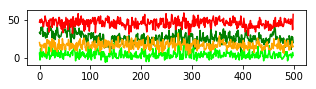

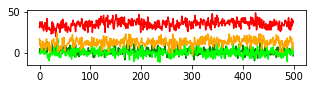

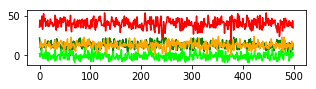

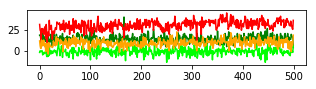

In [22]:
for i in range(len(sele_traces)):
    plt.figure(figsize = (5, 1))
    for j in range(4):
        plt.plot(range(500), sele_toi2[i, j], color = colors[j])

In [115]:
sele_avg2 = np.mean(sele_toi2, axis=2)

In [118]:
leakage_cf5 = []
for i in range(len(sele_traces2)):
    leakage_cf5.append(sele_avg2[i, 3]/sele_avg2[i, 2])
leakage[2, 3] = np.mean(leakage_cf5)

In [120]:
np.mean(leakage_cf5)

0.3349036856391455

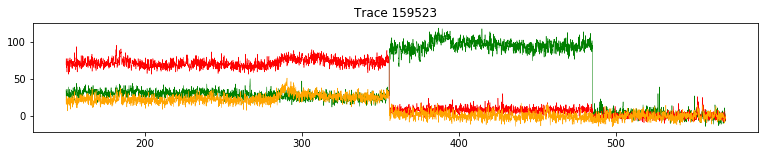

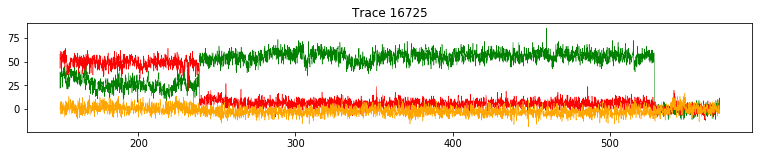

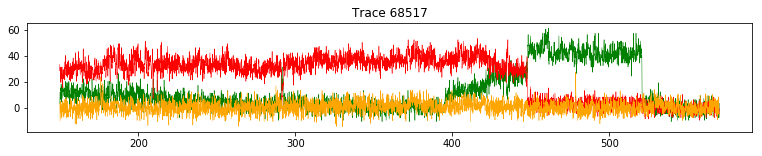

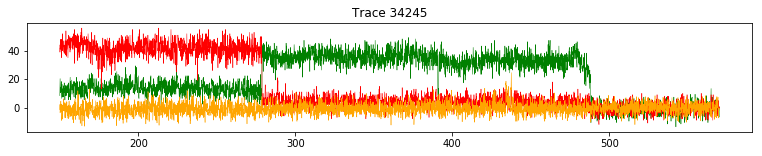

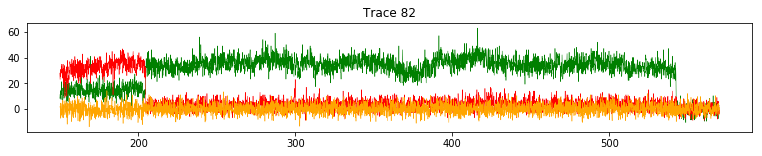

In [32]:
sele_traces = [159523, 16725, 68517, 34245, 82]

for i in range(len(sele_traces)):
    traceID = sele_traces[i]
    plt.figure(figsize=(13, 2))
#     plot_one_trace(traces - np.mean(traces[traceID, :, -10:], axis=1), traceID, time_axis[foi])
    background = np.mean(traces[traceID, :, -100:], axis=1)
    corrected = np.zeros((4, n_frames))
    for j in [0, 2, 3]:
        if i < 5:
            corrected[j] = traces[traceID, j, :] - background[j]
        else:
            corrected[j] = traces[traceID, j, :]
        if j > 0:
            corrected[j] = corrected[j] - leakage[0, j] * corrected[0]
        if j > 1:
            corrected[j] = corrected[j] - leakage[1, j] * corrected[1]
        if j > 2:
            corrected[j] = corrected[j] - leakage[2, j] * corrected[2]
        plt.plot(time_axis[foi], corrected[j] , c=colors[j], linewidth=.5)
    plt.title("Trace " + str(traceID))
    plt.savefig(sample_prefix + "_trc_" + str(traceID)+ "_lk&bg_corrected.png", dpi=200)
#     rel_range = sele_ranges[i] - 1500
#     plt.plot(time_axis[sele_ranges[i]],corrected[2, rel_range] , c='k', linewidth=.5)
#     sele_toi2[i] = corrected[:, rel_range]
#     rel_range = sele_ranges[i] - 1500
#     plt.plot(time_axis[sele_ranges[i]],traces[traceID, 0, rel_range] - background[0] , c='k', linewidth=.5)

69.2458014079827 -0.3839502183655148 24.724705882352936 88.57176470588233
24.47176012714242 0.7651064131497676 12.240588235294116 34.68764705882353
18.46872697725063 -0.07777298074518252 15.187058823529412 32.86352941176471
34.82884757977313 0.07471134923612356 23.62470588235294 56.24235294117648
54.165295035738936 12.502167339962028 22.24941176470588 60.32


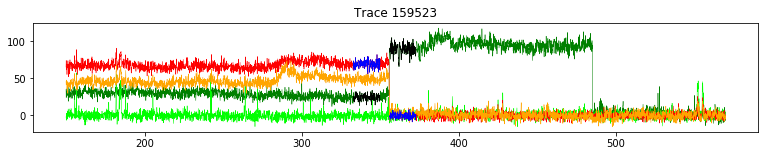

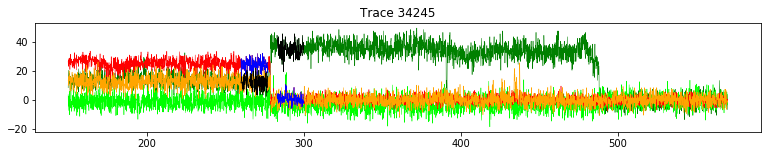

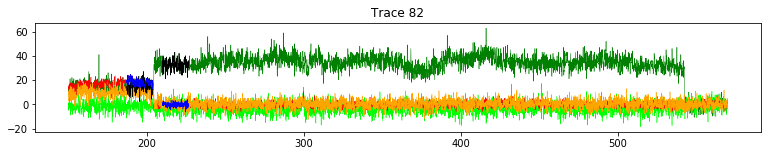

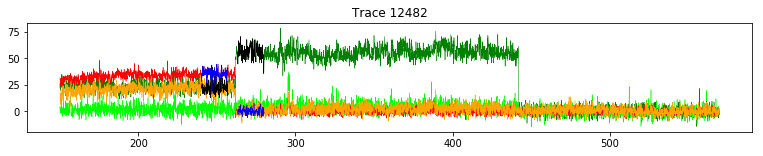

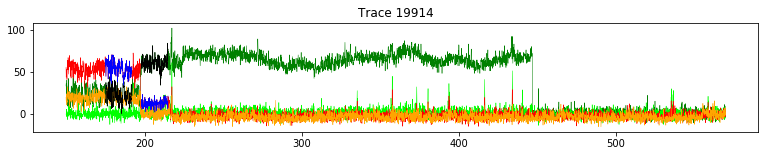

In [25]:
sele_traces = [159523, 34245, 82, 12482, 19914]
sele_ranges = [3530, 2800, 2070, 2600, 1950]
gamma_list = [1.0085682697623002, 1.6278825995807125, 1.8559068219633943, 1.3945897204688906, 0.9680160692212608]
sele_traces_corrected = np.zeros((len(sele_traces), 4, n_frames))

for i in range(len(sele_traces)):
    traceID = sele_traces[i]
    plt.figure(figsize=(13, 2))
#     plot_one_trace(traces - np.mean(traces[traceID, :, -10:], axis=1), traceID, time_axis[foi])
    background = np.mean(traces[traceID, :, -100:], axis=1)
    corrected = np.zeros((4, n_frames))
    for j in range(4):
        if i < 5:
            corrected[j] = traces[traceID, j, :] - background[j]
        else:
            corrected[j] = traces[traceID, j, :]
        if j > 0:
            corrected[j] = corrected[j] - leakage[0, j] * corrected[0]
        if j > 1:
            corrected[j] = corrected[j] - leakage[1, j] * corrected[1]
        if j > 2:
            corrected[j] = corrected[j] - leakage[2, j] * corrected[2]
        if j == 2:
            corrected[j] = corrected[j] / gamma_list[i]
        plt.plot(time_axis[foi], corrected[j] , c=colors[j], linewidth=.5)
    sele_traces_corrected[i] = corrected
    plt.title("Trace " + str(traceID))
    
    bleach_pt = sele_ranges[i]
    bef_bleach = np.arange(bleach_pt - 200, bleach_pt - 30)
    aft_bleach = np.arange(bleach_pt + 30, bleach_pt + 200)
    
    rel_bleach_pt = sele_ranges[i] - 1500
    rel_bef_bleach = np.arange(rel_bleach_pt - 200, rel_bleach_pt - 30)
    rel_aft_bleach = np.arange(rel_bleach_pt + 30, rel_bleach_pt + 200)
    
    plt.plot(time_axis[bef_bleach],corrected[0, rel_bef_bleach] , c='k', linewidth=.5)
    plt.plot(time_axis[bef_bleach],corrected[2, rel_bef_bleach] , c='b', linewidth=.5)
    plt.plot(time_axis[aft_bleach],corrected[0, rel_aft_bleach] , c='k', linewidth=.5)
    plt.plot(time_axis[aft_bleach],corrected[2, rel_aft_bleach] , c='b', linewidth=.5)
    
    r_bef = np.mean(corrected[2, rel_bef_bleach])
    r_aft = np.mean(corrected[2, rel_aft_bleach])
    g_bef = np.mean(corrected[0, rel_bef_bleach])
    g_aft = np.mean(corrected[0, rel_aft_bleach])
    print(r_bef, r_aft, g_bef, g_aft)
    
#     gamma_list.append((r_bef - r_aft)/(g_aft - g_bef))
    
    
#     sele_toi2[i] = corrected[:, rel_range]
#     rel_range = sele_ranges[i] - 1500
#     plt.plot(time_axis[sele_ranges[i]],traces[traceID, 0, rel_range] - background[0] , c='k', linewidth=.5)

In [26]:
don = sele_traces_corrected[:, 0, :]
acc = sele_traces_corrected[:, 2, :]
fret = np.zeros((len(sele_traces), n_frames), dtype=np.float32)
for i in range(len(sele_traces)):
    fret[i] = acc[i] / (don[i] + acc[i])
    for j in range(n_frames):
        if fret[i, j] < -0.1 or fret[i, j] > 1.1:
            fret[i, j] = 0

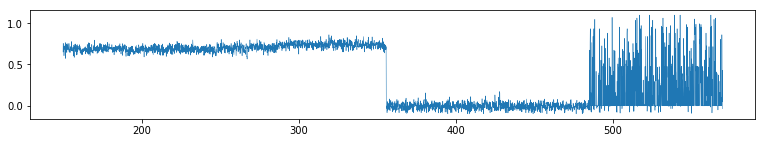

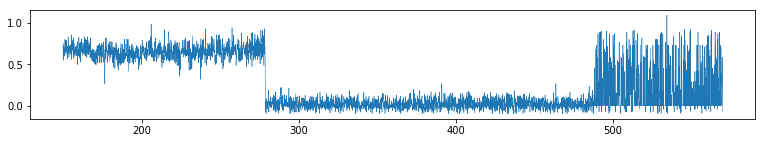

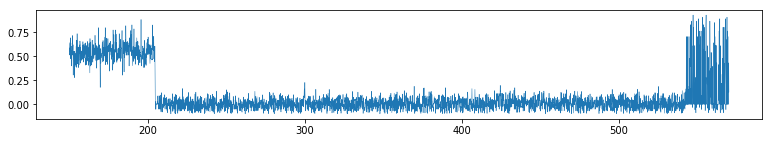

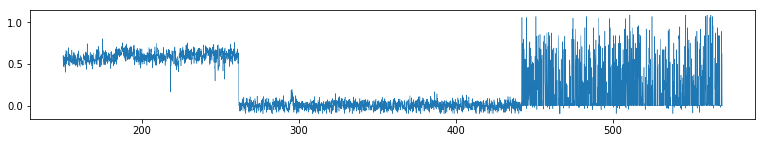

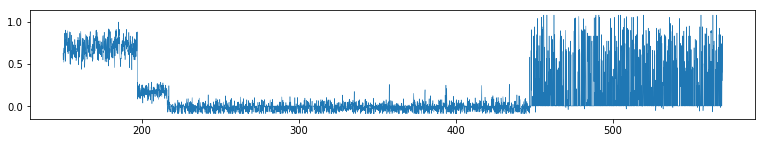

In [27]:
for i in range(len(sele_traces)):
    plt.figure(figsize=(13, 2))
    plt.plot(time_axis[foi], fret[i], linewidth=0.5)

In [81]:
acc[0]/(don[0] + acc[0])

array([0.66111589, 0.76004208, 0.6876262 , ..., 0.12220496, 0.45759728,
       0.05345885])

In [30]:
np.mean(gamma_list)

1.3709926961993117